In this project, we will use a logistic regression model to predict whether an individual's annual income exceeds $50,000 given attributes about their educational and ethnic background, working class, and a few other features provided in [this](https://archive.ics.uci.edu/ml/datasets/adult) dataset from the UCI Machine Learning Repository.

In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

First, we import the data.

In [46]:
cols = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', \
        'marital-status', 'occupation', 'relationship', 'race', 'sex', \
        'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', \
        'income']
df_orig = pd.read_csv('adult.data', names=cols, index_col=False, sep=', ', engine='python')
df = df_orig.copy()
df.head()

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


It is worth noting the missing values in some of the variables, denoted by a '?'.

In [47]:
print('Number of missing values for each variable:')
for col in df:
    vc = df[col].value_counts()
    num_missing = 0
    if '?' in vc.index:
        num_missing = vc['?']
    print('  ', col, ':', num_missing)

Number of missing values for each variable:
   age : 0
   workclass : 1836
   fnlwgt : 0
   education : 0
   education-num : 0
   marital-status : 0
   occupation : 1843
   relationship : 0
   race : 0
   sex : 0
   capital-gain : 0
   capital-loss : 0
   hours-per-week : 0
   native-country : 583
   income : 0


There are a number of ways of dealing with this issue. The simplest method is to drop all observations with missing values. However, this is not ideal as we are losing valuable data in the other variables associated with the dropped observations. For continuous variables, a common technique is to replace the missing values with a logical/unimpeding guess. Depending on the situation, this is usually either a zero or the mean or median of the rest of the values for that variable. A more sophisticated way of filling the missing values is to employ a technique called KNN imputation. In this technique, the observations with no missing values are used as training data to train a k-nearest neighbours algorithm, which predicts the missing values. This can be easily implemented using the `sklearn`'s `impute.KNNImputer` class. In our case, we will keep the missing values as their own unknown/other category.

Some of the variables may require some explanation. `fnlwgt` is the final weight, which is the number of people the census believes this entry represents. For simplicity of analysis, and since it is more a quality of the population than the individual, this variable will be dropped. The variable `education-num` is an ordinal encoding of the `education` variable. The ordinal encoding will be more useful for our classification algorithm, so the education column will be removed. `relationship` represents the respondents' role in the family, which can be assessed from gender and marital status, so it, too, will be discarded. `capital-gain` and `capital-loss` represent income from sources other than wage or salary, such as investment income.

In [48]:
df = df.drop(['education', 'relationship', 'fnlwgt'], axis=1)

The variable `workclass` stands for the industry in which the responding unit is employed.

In [49]:
df.workclass.value_counts()

Private             22696
Self-emp-not-inc     2541
Local-gov            2093
?                    1836
State-gov            1298
Self-emp-inc         1116
Federal-gov           960
Without-pay            14
Never-worked            7
Name: workclass, dtype: int64

There are two small classes: `Without-pay` and `Never-worked`. I will combine these with the unknown class, `?`, in a category called `Other`.  To simplify the analysis, we can group those who work for the government into a `Government` class, and both self-employed classes, incorporated and not incorporated, into a single one.

In [50]:
df.workclass = df.workclass.map({'?':'Other', 'Without-pay':'Other', 'Never-worked':'Other',\
                                 'Local-gov':'Government', 'State-gov':'Government', 'Federal-gov':'Government',\
                                 'Self-emp-not-inc':'Self-employed', 'Self-emp-inc':'Self-employed',\
                                 'Private':'Private'})
df.workclass.value_counts()

Private          22696
Government        4351
Self-employed     3657
Other             1857
Name: workclass, dtype: int64

To investigate the distribution of the `workclass` variable and its relationship with our target variable `income`, we can plot a bar plot of the `workclass` variable, coloured by `income`. 

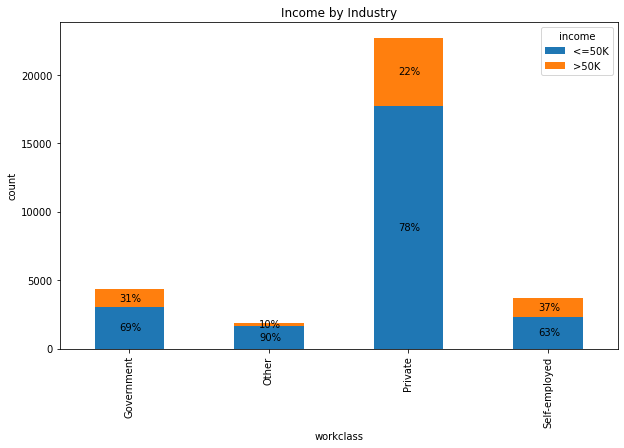

In [51]:
df_plot = df.groupby(['workclass', 'income']).size().reset_index().pivot(columns='income', \
                                                                         index='workclass', values=0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Industry')
plt.ylabel('count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    ax.annotate(str(annotations[i]) + '%', (p.get_x()+.18, p.get_y()+p.get_height()//2-200))

Those who are self employed have the greatest tendency of making more than $50,000 annually, while those with other or unknown employment have the lowest tendency.

We can create a similar plot for the `education-num` variable.

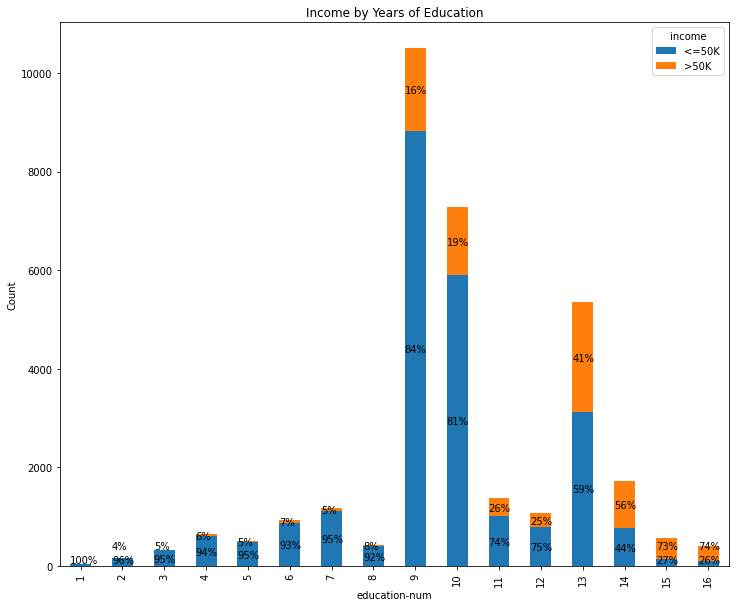

In [52]:
df_plot = df.groupby(['education-num', 'income']).size().reset_index().pivot(columns='income', \
                                                            index='education-num', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(12,10))
plt.title('Income by Years of Education')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()
    y = max(p.get_y()+p.get_height()//2-80, 60)
    if i >= len(annotations)//2:
        y = max(y, 350)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

Perhaps unsuprisingly, the proportion of people making more than $\$$50,000 annually increases with years of education. Nearly three quarters of those with doctoral degrees (16) make more than $\$$50,000 per year, while less than 10% of those with a high school education (8) or less make over $\$$50,000 annually.

In [53]:
df.occupation.value_counts()

Prof-specialty       4140
Craft-repair         4099
Exec-managerial      4066
Adm-clerical         3770
Sales                3650
Other-service        3295
Machine-op-inspct    2002
?                    1843
Transport-moving     1597
Handlers-cleaners    1370
Farming-fishing       994
Tech-support          928
Protective-serv       649
Priv-house-serv       149
Armed-Forces            9
Name: occupation, dtype: int64

To simplify the `occupation` variable, I will group together the given categories into `White-collar`, `Professional`, `Sales`, `Service`, and `Blue-collar` categories.  Because of the low number of observations with the `Armed-Forces` value, I will group them with the unknowns in a category called `Other`.

In [54]:
df.occupation = df.occupation.map({'Prof-specialty':'Professional', 'Craft-repair':'Blue-collar', \
                        'Exec-managerial':'White-collar', 'Adm-clerical':'White-collar', \
                        'Machine-op-inspct':'Blue-collar', 'Transport-moving':'Blue-collar', \
                        'Handlers-cleaners':'Blue-collar', 'Farming-fishing':'Blue-collar', \
                        'Other-service':'Service', 'Tech-support':'Service', 'Protective-serv':'Service', \
                        'Priv-house-serv':'Service', 'Sales':'Sales', \
                        '?':'Other', 'Armed-Forces':'Other'})
df.occupation.value_counts()

Blue-collar     10062
White-collar     7836
Service          5021
Professional     4140
Sales            3650
Other            1852
Name: occupation, dtype: int64

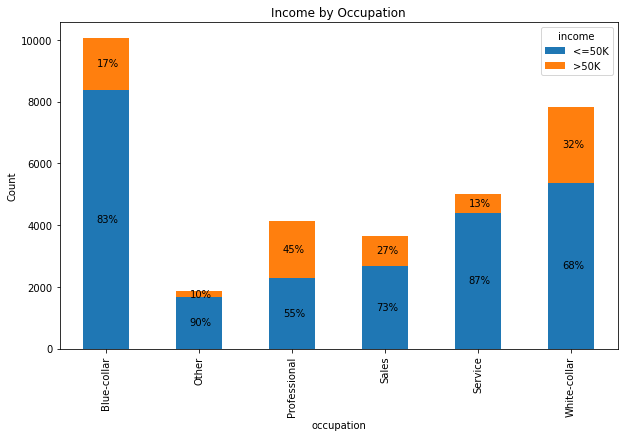

In [55]:
df_plot = df.groupby(['occupation', 'income']).size().reset_index().pivot(columns='income', index='occupation', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Occupation')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()+.15
    y = p.get_y()+p.get_height()//2-80
    if i >= len(annotations)//2:
        y = max(y, 350)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

It is notable that income varies greatly across different occupations.  Nearly half of those with a professional occupation make over $\$$50,000 annually, however only 13% of service workers make over $\$$50,000 per year.

The categorical `marital-status` variable will be simplified for analysis as well.

In [56]:
df['marital-status'].value_counts()

Married-civ-spouse       14976
Never-married            10683
Divorced                  4443
Separated                 1025
Widowed                    993
Married-spouse-absent      418
Married-AF-spouse           23
Name: marital-status, dtype: int64

The `Married-civ-spouse`, `Married-spouse-absent`, and `Married-AF-spouse` categories will be combined into a `Married` variable.

In [57]:
df['marital-status'] = df['marital-status'].map({'Never-married':'Single', \
            'Married-civ-spouse':'Married', 'Married-spouse-absent':'Married', 'Married-AF-spouse':'Married', \
            'Divorced':'Divorced', 'Separated':'Separated', 'Widowed':'Widowed'})
df['marital-status'].value_counts()

Married      15417
Single       10683
Divorced      4443
Separated     1025
Widowed        993
Name: marital-status, dtype: int64

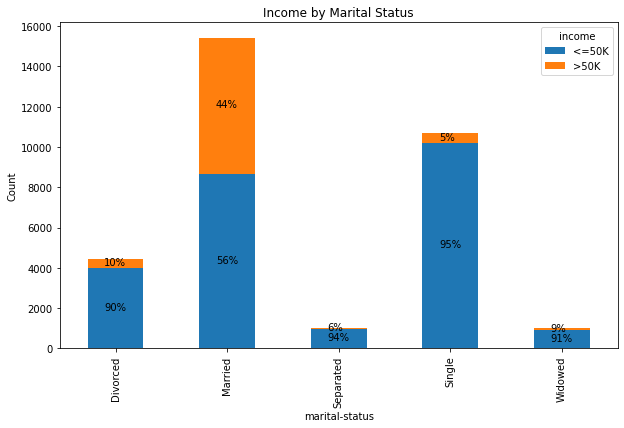

In [58]:
df_plot = df.groupby(['marital-status', 'income']).size().reset_index().pivot(columns='income', \
                                                            index='marital-status', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Marital Status')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()+.15
    y = p.get_y()+p.get_height()//2-80
    if i >= len(annotations)//2:
        y = max(y, 350)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

Almost half of married people make over $\$$50,000 annually, however, less than 10% of the rest of the respondents do.

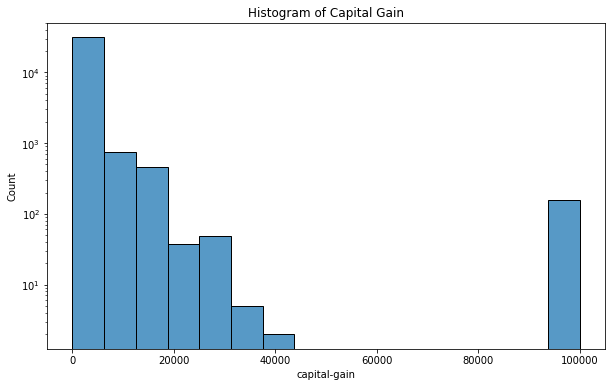

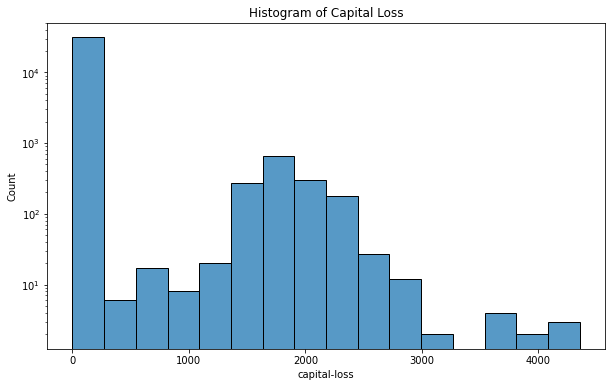

In [59]:
plt.figure(figsize=(10,6))
sns.histplot(df['capital-gain'])
plt.title('Histogram of Capital Gain')
plt.yscale('log')

plt.figure(figsize=(10,6))
sns.histplot(df['capital-loss'], label='capital loss')
plt.title('Histogram of Capital Loss')
plt.yscale('log')

In [60]:
print('Proportion of zeros [capital-gain]: %.1f%%' % (100*len(df[df['capital-gain'] == 0])/len(df)))
print('Proportion of zeros [capital-loss]: %.1f%%' % (100*len(df[df['capital-loss'] == 0])/len(df)))

Proportion of zeros [capital-gain]: 91.7%
Proportion of zeros [capital-loss]: 95.3%


As is clear from the above histograms (note the logarithmic scaling on the vertical axis) and computation, the `capital-gain` and `capital-loss` variables are both quite skewed, with a high proportion of zero values.  Thus, we will exclude them from the dataset.

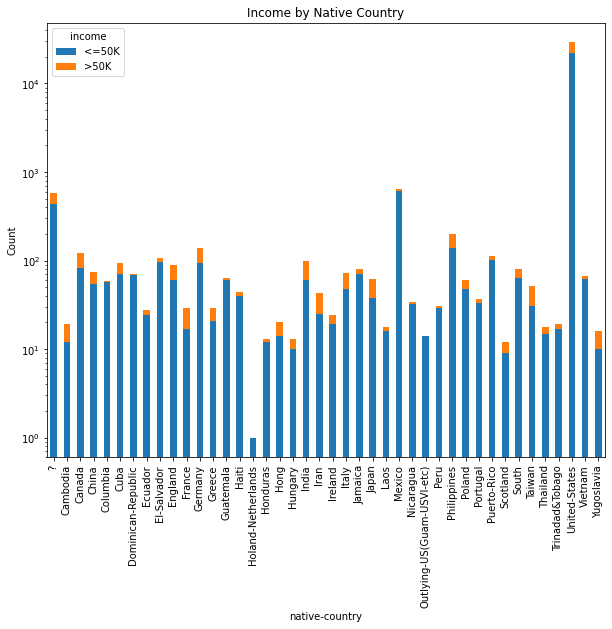

In [61]:
df_plot = df.groupby(['native-country', 'income']).size().reset_index().pivot(columns='income', \
                                                                index='native-country', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,8))
plt.title('Income by Native Country')
plt.ylabel('Count')
plt.yscale('log')

Similarly, the `native-country` variable displays high skewness as most observations are from the United States (again note the logarithmic scaling of the vertical axis on the above plot).  Hence, we will exclude this variable from our model as well.

In [62]:
df = df.drop(['capital-gain', 'capital-loss', 'native-country'], axis=1)

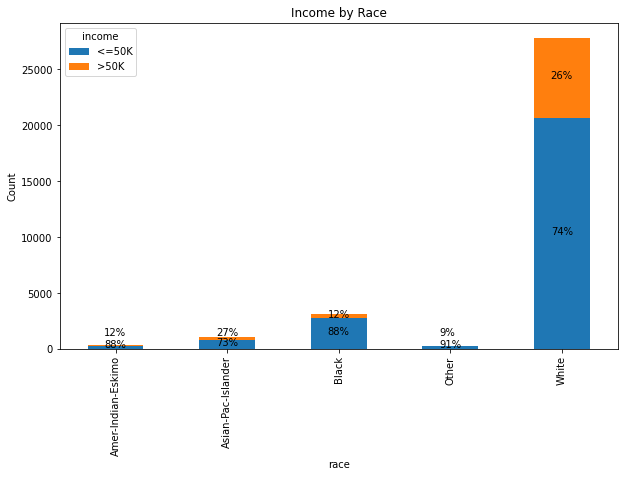

In [63]:
df_plot = df.groupby(['race', 'income']).size().reset_index().pivot(columns='income', \
                                                                    index='race', values=0).fillna(0)
ax = df_plot.plot(kind='bar', stacked=True, figsize=(10,6))
plt.title('Income by Race')
plt.ylabel('Count')

annotations = df_plot.divide(df_plot.sum(axis=1), axis='index')
annotations = np.array(100*annotations).round().astype(int)
annotations = annotations.flatten(order='F')
for i, p in enumerate(ax.patches):
    if annotations[i] == 0:
        continue
    x = p.get_x()+.15
    y = max(p.get_y()+p.get_height()//2-80, 120)
    if i >= len(annotations)//2:
        y = max(y, 1200)
        
    ax.annotate(str(annotations[i]) + '%', (x, y))

From the above plot, we see that the majority of respondents are white, and that white and asian-pacific islanders have the largest proportions of individuals earning more than $\$$50,000 per year.

Text(0.5, 1.0, 'Histograms of Age by Gender')

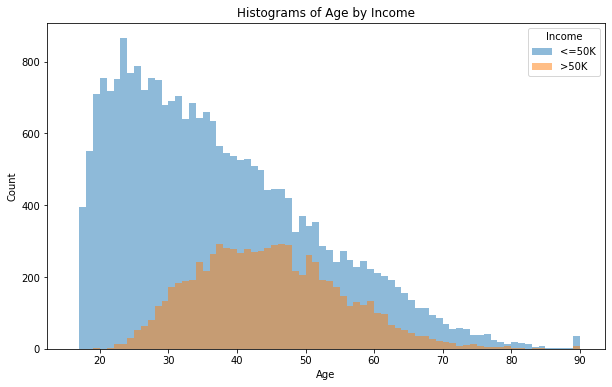

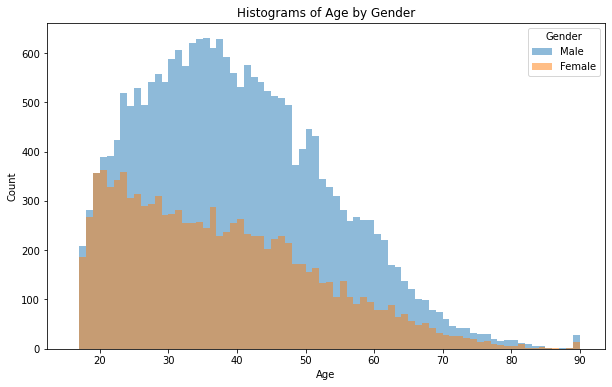

In [64]:
# Age hist by income
plt.figure(figsize=(10,6))
bins = np.linspace(min(df.age) - 1, max(df.age), max(df.age) - min(df.age) + 2)

plt.hist(df.age[df.income == '<=50K'], bins, alpha=0.5, label='<=50K')
plt.hist(df.age[df.income == '>50K'], bins, alpha=0.5, label='>50K')
plt.legend(loc='upper right', title='Income')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histograms of Age by Income')

# Age hist by gender
plt.figure(figsize=(10,6))
bins = np.linspace(min(df.age) - 1, max(df.age), max(df.age) - min(df.age) + 2)

plt.hist(df.age[df.sex == 'Male'], bins, alpha=0.5, label='Male')
plt.hist(df.age[df.sex == 'Female'], bins, alpha=0.5, label='Female')
plt.legend(loc='upper right', title='Gender')
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Histograms of Age by Gender')

Inspecting the distribution of the age variable, we see that there are significantly more observations for those who make less than $\$$50,000 annually than those who make more.  Moreover, those who make more than $50,000 annually tend to be in their mid-career.

Interestingly, females are underrepresented in the dataset, which could be caused by a census bias.

Text(0.5, 1.0, 'Distributions of Hours per Week by Income')

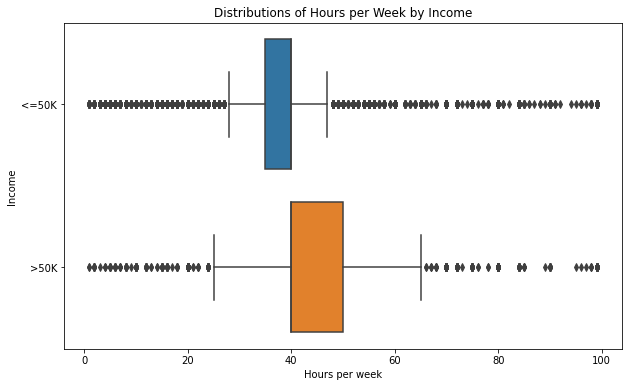

In [65]:
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='hours-per-week', y='income')

plt.xlabel('Hours per week')
plt.ylabel('Income')
plt.title('Distributions of Hours per Week by Income')

Unsuprisingly, we see that those who make more than $\$$50,000 annually tend to work more hours per week than those who make less. Also, it is notable that the distribution of hours worked has a larger spread for those who make more than $\$$50,000 per year than those who don't.

In order to perform logistic regression on the dataset, we need to numerically encode the categorical variables. For binary variables, such as our `sex` and `income` variables, we can simply map these to 0 and 1. If a logical order is present in the features, mapping the features to a range of consecutive integers is a common technique. This quantifies the data while maintaining the ordinal nature of the variable. This is what was previously done to create the `education-num` variable from the `education` variable.

When a logical order is not present in the features, as is the case in our remaining categorical variables, a one-hot encoding is a common technique to quantify the categorical data. Here, each category is mapped to a vector containing a 1 or 0 to denote the presence or absence of a feature. For instance, our `marital-status` variable could represent 'Single' as $[0,1,0,0,0]$, where the vector entries correspond to 'Married', 'Single', 'Divorced', 'Separated', and 'Widowed' respectively. This method can cause issues for variables with large cardinality as it drastically increases the sparsity of the dataset, however it is a good way to quantify our data. This method can be easily implemented with the `pandas` method `get_dummies`.

In [66]:
df.sex = df.sex.map({'Male':0, 'Female':1})
df.income = df.income.map({'<=50K':0, '>50K':1})
df = pd.get_dummies(df, columns=['workclass', 'marital-status', 'occupation', 'race'])
df.head()

,age,education-num,sex,hours-per-week,income,workclass_Government,workclass_Other,workclass_Private,workclass_Self-employed,marital-status_Divorced,...,occupation_Other,occupation_Professional,occupation_Sales,occupation_Service,occupation_White-collar,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White
0,39,13,0,40,0,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
1,50,13,0,13,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,38,9,0,40,0,0,0,1,0,1,...,0,0,0,0,0,0,0,0,0,1
3,53,7,0,40,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,28,13,1,40,0,0,0,1,0,0,...,0,1,0,0,0,0,0,1,0,0


We will preform the regression with the machine learning library PyTorch.

In [67]:
import torch as t
from torch import nn
from torch.optim import SGD
from torch.utils.data import Dataset, DataLoader, random_split

The data is split into training and validation sets and the independent variables in both sets are standardized using the mean and standard deviation of the training dataset. This is best done in PyTorch by creating a class representing the data, and creating DataLoader objects to iterate over the training and validation datasets.

In [68]:
class Data(Dataset):
    def __init__(self, df):
        self.data = df.drop('income', axis=1).copy()
        self.income = t.Tensor(df.income.copy()).type(t.float)
        self.data = t.Tensor(self.data.to_numpy()).type(t.float)
        
    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, i):
        return (self.data[i], self.income[i])

In [69]:
dataset = Data(df)

# Split the data into training and validation subsets
train_fraction = 0.75
train_len = int(train_fraction*len(dataset))
train, valid = random_split(dataset, (train_len, len(dataset) - train_len))

# Standardize the data based on the training data mean and std
train_mean = t.mean(train.dataset.data[train.indices], 0)
train_std = t.std(train.dataset.data[train.indices], 0)
train.dataset.data[train.indices] = (train.dataset.data[train.indices] - train_mean)/train_std
valid.dataset.data[valid.indices] = (valid.dataset.data[valid.indices] - train_mean)/train_std

train_loader = DataLoader(train, batch_size=len(dataset), shuffle=False)
valid_loader = DataLoader(valid, batch_size=len(dataset), shuffle=False)

We then define a simple class representing our model.

In [70]:
class LinearRegression(nn.Module):
    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        
        self.linear = nn.Linear(input_size, output_size)
    
    def forward(self, x):
        return self.linear(x)

model = LinearRegression(df.shape[1] - 1, 1)

The goal of our model is to find parameters $m_1,...,m_n,b$ such that the target variable `income`, denoted $y_{income}$, is given by  $$y_{income} = \sigma(m_1x_1 + ... + m_nx_n + b)$$ where the $x_i$ are our training variables (age, workclass, etc.).  Here, $\sigma$ is known as the *sigmoid function* and is given by $$\sigma:\mathbb{R} \rightarrow (0,1), x \mapsto \frac{1}{1+e^{-x}}$$

For our loss function, we use the Binary Cross Entropy (BCE) loss. Of course, our model defined above does not include the sigmoid operation, it simply returns output of the linear operation. This is because, in PyTorch, it is more numerically stable to use the predefined loss function `torch.nn.BCEWithLogitsLoss`. This function applies the sigmoid operation and the loss calculation in one layer, but takes advantage of the [log-sum-exp trick](https://en.wikipedia.org/wiki/LogSumExp) for numerical stability.  Thus, this is favorable over consecutively applying the sigmoid function and then the BCE calculation to increae numerical stability.




In [71]:
lr = 0.03
n_epochs = 440

# This loss function combines a sigmoid function with a binary cross entropy loss function.
# It is preferred to increase numerical stability.
loss_func = nn.BCEWithLogitsLoss()

optimizer = SGD(model.parameters(), lr=lr)

We set the batch size equal to the length of the full dataset so that the entire training set is used on every parameter update.  For a simple model such as this logistic regression model, it is not necessary to split the data into batches.

In [72]:
l = []
model.train()
for i, epoch in enumerate(range(n_epochs)):
    for x, label in train_loader:
        
        optimizer.zero_grad()

        prediction = model(x)

        loss = loss_func(prediction, label.unsqueeze(1))
        l.append(loss.detach())

        loss.backward()

        optimizer.step()
        
        if i % 20 == 0:
            print('Epoch %i' % i, ' Loss %.3f' % loss)

Epoch 0  Loss 0.760
Epoch 20  Loss 0.646
Epoch 40  Loss 0.577
Epoch 60  Loss 0.532
Epoch 80  Loss 0.500
Epoch 100  Loss 0.477
Epoch 120  Loss 0.460
Epoch 140  Loss 0.446
Epoch 160  Loss 0.435
Epoch 180  Loss 0.426
Epoch 200  Loss 0.419
Epoch 220  Loss 0.413
Epoch 240  Loss 0.407
Epoch 260  Loss 0.403
Epoch 280  Loss 0.399
Epoch 300  Loss 0.396
Epoch 320  Loss 0.393
Epoch 340  Loss 0.390
Epoch 360  Loss 0.388
Epoch 380  Loss 0.386
Epoch 400  Loss 0.385
Epoch 420  Loss 0.383


Text(0.5, 1.0, 'Mean BCE Loss vs Training Epoch')

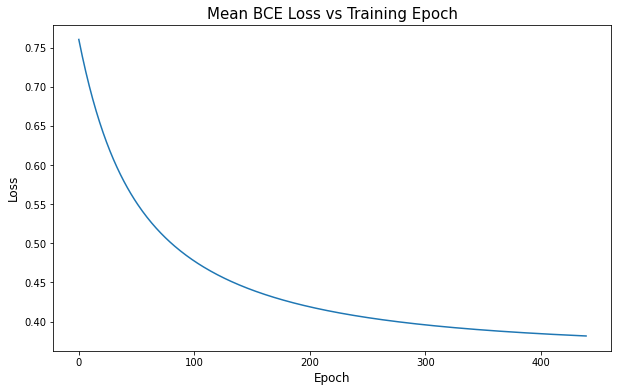

In [73]:
plt.figure(figsize=(10,6))
plt.plot(range(len(l)), l)
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Epoch', fontsize=12)
plt.title('Mean BCE Loss vs Training Epoch', fontsize=15)

Now, we can test our model to see how it performs on the validation dataset. The output of the logistic regression algorithm is a probability that an individual makes more than $\$$50,000 annually. Thus, we will use a threshold of 0.5 to determine whether an individual is predicted to make more than $50,000 or not.

In [74]:
model.eval()
valid_data, valid_income = [*valid_loader][0]
thres = 0.5
pred_income_probabilities = nn.Sigmoid()(model(valid_data)).squeeze().detach()
pred_income = t.where(pred_income_probabilities > thres, 1, 0)
valid_income = valid_income.detach().numpy().astype(int)
pred_income = pred_income.detach().numpy().astype(int)

In [75]:
acc_valid = (valid_income == pred_income).sum()/len(valid_income)
print('Accuracy on validation set: %.2f%%' % (100*acc_valid))

Accuracy on validation set: 82.52%


We achieve a fairly good accuracy for the model.  To check for overfitting, we can compare the above accuracy with the accuracy on the training data.

In [76]:
# Accuracy for train data
train_data, train_income = [*train_loader][0]
pred_train = t.where(nn.Sigmoid()(model(train_data)).squeeze() > thres, 1, 0)
pred_train = pred_train.detach().numpy().astype(int)
train_income = train_income.detach().numpy().astype(int)

acc_train = (pred_train == train_income).sum()/len(train_income)
print('Accuracy on training set: %.2f%%' % (100*acc_train))

Accuracy on training set: 82.50%


The similar accuracy on both datasets indicates the model is not overfitting the training dataset.

A confusion matrix will give us more insight into how well our model is performing.

In [77]:
cf_matrix = np.zeros((2,2))
for real, pred in zip(valid_income, pred_income):
    cf_matrix[real][pred] += 1
    
print('Confusion matrix:')
pd.DataFrame(cf_matrix, index=['actual_<=50k', 'actual_>50k'], \
             columns=['predicted_<=50k', 'predicted_>50k']).astype(int)

Confusion matrix:


,predicted_<=50k,predicted_>50k
actual_<=50k,5653,518
actual_>50k,905,1065


In [78]:
print('Normalized confusion matrix:')
pd.DataFrame(cf_matrix/cf_matrix.sum(), index=['actual_<=50k', 'actual_>50k'], \
             columns=['predicted_<=50k', 'predicted_>50k'])

Normalized confusion matrix:


,predicted_<=50k,predicted_>50k
actual_<=50k,0.694386,0.063629
actual_>50k,0.111166,0.130819


From the confusion matrix, we can calculate a few other metrics for evaluating out model.  First, we compute the misclassification rate, which is simply the fraction of predictions that were wrong.

In [79]:
misclass_rate = (cf_matrix[0][1]+cf_matrix[1][0])/cf_matrix.sum()
print('Misclassification rate: %.2f%%' % (100*misclass_rate))


Misclassification rate: 17.48%


We can also compute the recall, precision, and $F_1$ score.  Recall measures the proportion of actual positives that were identified correctly. That is, recall is defined as 

$$\text{Recall} = \frac{\text{True Positives}}{\text{True Positives}+\text{False Negatives}}$$

Precision, on the other hand, is the proportion of positive identifications that were correct. Hence, precision is given by 

$$\text{Precision} = \frac{\text{True Positives}}{\text{True Positives}+\text{False Positives}}$$

It is important to consider both these metrics when evaluating a classification model as it is possible to have high recall but low precision or vice versa.

$F_1$ score is a single metric which combines both the precision and recall.  It is given by the harmonic mean of precision and recall:

$$F_1=2\cdot\frac{\text{Recall}\cdot\text{Precision}}{\text{Recall}+\text{Precision}}$$

$F_1$ score is a useful metric since it is low if either precision or recall are low and allows us do sufficiently describe the effectiveness of our model in a single quantity.

In [80]:
recall = cf_matrix[1][1]/cf_matrix[1].sum()
print('Recall: ', recall)

precision = cf_matrix[1][1]/cf_matrix.sum(axis=0)[1]
print('Precision: ', precision)

f1 = 2*precision*recall/(precision + recall)
print('F1 score: ', f1)

Recall:  0.5406091370558376
Precision:  0.6727732154137713
F1 score:  0.5994933858710949


Our model has a greater precision than recall, and a decent $F_1$ score.

The ROC curve is a plot of the false positive rate on the horizontal axis versus the true positive rate on the vertical axis for thresholds varying from 0 to 1. It is particularly useful for directly comparing several models, however, for a single model, the area under the ROC curve (AUC) can be used as a summary of the model's effectiveness.

In [81]:
from sklearn.metrics import roc_curve, roc_auc_score

Text(0.5, 1.0, 'ROC Curve')

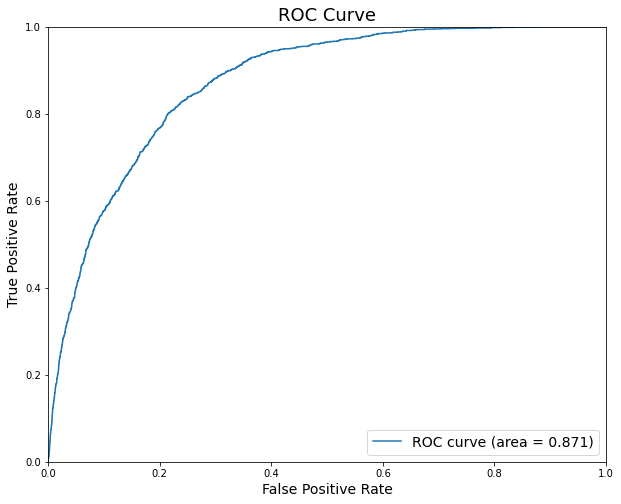

In [82]:
fpr, tpr, thresholds = roc_curve(valid_income, pred_income_probabilities)
area = roc_auc_score(valid_income, pred_income_probabilities)
plt.figure(figsize=(10,8))
plt.plot(fpr, tpr)
plt.xlim(0,1)
plt.ylim(0,1)
plt.legend(['ROC curve (area = %.3f)' % area], loc='lower right', fontsize=14)
plt.xlabel('False Positive Rate', fontsize=14)
plt.ylabel('True Positive Rate', fontsize=14)
plt.title('ROC Curve', fontsize=18)

Since the data is standardized before training, we can use the coefficients of our logistic regression model to determine the relative importance of each feature in predicting the class of a data sample, as well as if they contribute positively or negatively to the classification.

In [83]:
param = [*model.parameters()][0]
for feature, coeff in sorted(zip(df.drop(['income'], axis=1).columns, param[0]), key=lambda x: -abs(x[1])):
    print(feature, ':', (26 - len(feature) + int(np.floor(coeff.item())))*' '  + '%.4f' % coeff.item())

marital-status_Married :     0.5171
education-num :              0.4623
marital-status_Single :     -0.3383
hours-per-week :             0.2697
occupation_Blue-collar :    -0.2584
age :                        0.2517
marital-status_Divorced :   -0.1803
sex :                       -0.1669
workclass_Other :           -0.1441
marital-status_Widowed :    -0.1403
occupation_Professional :    0.1371
occupation_Service :        -0.1356
workclass_Private :         -0.1117
race_Black :                -0.1003
workclass_Self-employed :   -0.0933
occupation_White-collar :    0.0834
occupation_Other :          -0.0809
race_Other :                -0.0746
marital-status_Separated :  -0.0712
workclass_Government :      -0.0595
race_Amer-Indian-Eskimo :   -0.0487
occupation_Sales :          -0.0072
race_White :                -0.0027
race_Asian-Pac-Islander :   -0.0004


We see that `education-num` contributes among the most to the classification of a data sample, and does so in a positive way, whereas the `marital-status_Single` variable contributes strongly in a negative way.

In [84]:
import pickle
with open('income_and_predictions.pickle', 'wb') as f:
    pickle.dump([valid_income, pred_income_probabilities, acc_valid, f1], f)